<a href="https://colab.research.google.com/github/avk4714/DL_Projects/blob/master/Dropout_DNN_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of the Dropout Method to determine Cartpole dynamics**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import csv

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [0]:
class Net(nn.Module):
  def __init__(self, D_in1, n_hidden, D_out1, z_prob1, lam_mult1):
    super(Net, self).__init__()
    # Layers
    self.model_L_1 = torch.nn.Linear(D_in1, n_hidden, bias=True)
    self.model_D_1 = torch.nn.Dropout(p=z_prob1)
    self.model_L_2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_2 = torch.nn.Dropout(p=z_prob1)
    self.model_L_3 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_3 = torch.nn.Dropout(p=z_prob1)
    self.model_L_4 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_4 = torch.nn.Dropout(p=z_prob1)
    self.model_L_5 = torch.nn.Linear(n_hidden, D_out1, bias=True)

  def forward(self, x):
    pred_1 = self.model_D_1(F.relu(self.model_L_1(x)))
    pred_2 = self.model_D_2(F.relu(self.model_L_2(pred_1)))
    pred_3 = self.model_D_3(F.relu(self.model_L_3(pred_2)))
    pred_4 = self.model_D_4(F.relu(self.model_L_4(pred_3)))
    y_pred = self.model_L_5(pred_4)
    return y_pred

In [0]:
from numpy import genfromtxt

train_x = genfromtxt('train_x_data_2.csv', delimiter=',')
train_y = genfromtxt('train_y_data_2.csv', delimiter=',')
train_x_tnsr = torch.from_numpy(train_x).float()
train_y_tnsr = torch.from_numpy(train_y).float()
M = train_x_tnsr.shape[0]
train_data = TensorDataset(train_x_tnsr, train_y_tnsr)

In [0]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step


**Calling DNN for Model Training**

In [8]:
'''Training Parameter Settings'''
n_samples = 500
n_hidden = 1000
z_prob = 0.2
lam_mult = 1e-2
d_in = 6            # Inputs are: [p, dp, dtheta, sin(theta), cos(theta), action]
d_out = 4           # Outputs are: [ddtheta, ddp, dtheta, dp]
n_epochs = 1000
batch_size = 50

'''Load data as mini-batches'''
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

'''PyTorch Model Invocation'''
model = Net(d_in, n_hidden, d_out, z_prob, lam_mult).to(device)

'''Loss function and Optimizer'''
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=lam_mult)

'''Train Data'''
losses = []
train_step = make_train_step(model, criterion, optimizer)

for epoch in range(n_epochs):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    loss = train_step(x_batch, y_batch)
    losses.append(loss)
  
  if (epoch % 100) == 0:
    print('Epoch: %d -> Loss: %.5f' % (epoch, loss))
        
# print(model.state_dict())

# '''Creating additional set of input features to feed in'''
# train_x_tnsr = train_x_tnsr.to(device)
# train_y_tnsr = train_y_tnsr.to(device)
# '''Training runs'''
# loss_data = []
# for t in range(runs):
#   pred_y_tnsr = model(train_x_tnsr.float())
#   loss = criterion(pred_y_tnsr.float(), train_y_tnsr.float())
#   if t % 100 == 99:
#     loss_data.append([t, loss.item()])
#     print(t, loss.item())
  
#   # zero gradients, perform a backward pass and update the weights
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0 -> Loss: 47.22480
Epoch: 100 -> Loss: 3.19791
Epoch: 200 -> Loss: 1.27465
Epoch: 300 -> Loss: 1.73750
Epoch: 400 -> Loss: 1.03887
Epoch: 500 -> Loss: 0.71927
Epoch: 600 -> Loss: 0.92215
Epoch: 700 -> Loss: 0.59660
Epoch: 800 -> Loss: 1.03195
Epoch: 900 -> Loss: 0.95494


In [0]:
losses = np.array(losses)
l_M = losses.shape[0]
epochvec = np.linspace(0,l_M-1,num=l_M)

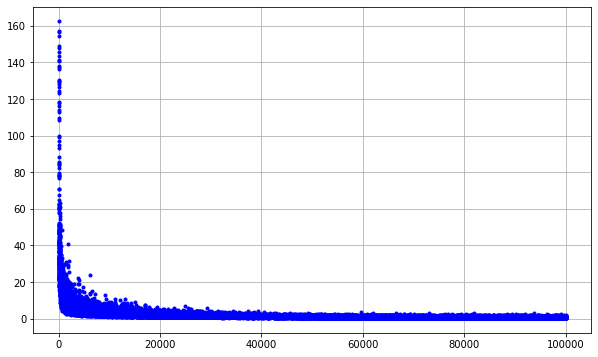

In [30]:
plt.figure(figsize=(10,6)) 
plt.plot(epochvec,losses,"b.")
plt.grid()
plt.show()

In [0]:
with open ('train_loss_6.csv', mode='w') as loss_dat:
  loss_write = csv.writer(loss_dat, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for loss_val in losses:
    loss_write.writerow([loss_val])

In [0]:
PATH = './cartpole_ReLU_2.pth'
torch.save(model.state_dict(), PATH)